In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib.animation import FuncAnimation

## The functions we'll need (library)

In [2]:
def get_positions(num_dims, num_cell, num_particles, box_length):
    spacing = box_length / num_cell
    positions_1D = np.linspace(spacing, box_length, num_cell)
    if (num_dims == 3):
        r = np.meshgrid(positions_1D, positions_1D, positions_1D)
    elif (num_dims == 2):
        r = np.meshgrid(positions_1D, positions_1D)
    
    r = np.reshape(r, (num_dims, num_particles))
    r = pbc(r, box_length)
    return r

In [3]:
def pbc(vec, box_length):
    iboxl = 1.0 / box_length
    return vec - box_length * np.round(vec * iboxl)

In [4]:
def get_momenta(num_dims, mass, temperature):
    num_particles = mass.shape[1]
    standard_dev = np.sqrt(temperature * mass) 
    mean = np.zeros(standard_dev.shape)
    return np.random.normal(mean, standard_dev, (num_dims, num_particles))

In [5]:
def LJ(dist):
    dr2 = dist*dist
    idr2 = 1/dr2
    idr6 = idr2*idr2*idr2
    dv = 4 * (idr6*idr6 - idr6)
    df = 48 * dist * idr2 * (idr6*idr6 - 0.5*idr6)
    return dv, df

In [6]:
# Can speed up by vectorizing over all particles
def interactions(r, boxl):
    num_dims, num_particles = r.shape
    forces = np.zeros((num_dims, num_particles))
    potential = 0
    for pA in range(num_particles-1):
        rA = np.reshape(r[:, pA], (num_dims, 1))
        rB = r[:, pA+1:]
        
        dr = pbc(rA - rB, boxl)
        
        dist = np.linalg.norm(dr, axis=0)
        
        dv, df = LJ(dist)
        
        potential = potential + np.sum(dv)
        
        forces[:, pA] = forces[:, pA] + np.sum(dr*df/dist, axis=1)
        forces[:, pA+1:] = forces[:,pA+1:] - dr*df/dist
                
    return potential, forces

In [7]:
def init():
    """initialize animation"""
    if num_dims == 2:
        particles.set_data(params['r'][0,:], params['r'][1,:])
    elif num_dims == 3:
        particles.set_data(params['r'][0,:], params['r'][1,:])
        particles.set_3d_properties(params['r'][2:])
    return particles


def update(frame, params, constants, file, visualize, ms):
    "simulation/animation update loop"
    global rect, ax, fig   # Probably should pass as args and not ref globals
    num_dims, temperature, dt, gamma, boxl, potE_0, kinE_0 = constants
    
    params['p']= params['p']+ 0.5*dt*params['forces']
    velocities = params['p']/ params['mass']
    
    # Evolve positions
    dr = dt*velocities
    params['r_noPBC'][:, :, frame+1] = params['r_noPBC'][:, :, frame] + dr
    params['r'] = pbc(params['r'] + dr, boxl)
    
    # Get potential energy and forces for new positions
    pe, params['forces'] = interactions(params['r'] , boxl)
    
    # Evolve momenta by dt/2
    params['p']= params['p']+ 0.5*dt*params['forces']
    
    # Thermostat the system: Anderson Thermostat
    if (np.random.uniform() < gamma*dt):
        params['p']= get_momenta(num_dims, params['mass'], temperature)
        
    # Print system properties
    ke = np.sum(np.square(params['p']) / (2 * params['mass']))
    tote = ke + pe
    T_obs = 2 * ke / (num_dims * num_particles)
    
    
    if frame % 10 == 0:
        paramstr = ("Time: %f, T: %3.4f, E: %10.4f, PE: %10.4f, KE: %10.4f\n" % 
              (frame*dt, T_obs, tote - (potE_0+kinE_0), pe-potE_0, ke-kinE_0))
        file.write(paramstr)
        
        
    if visualize:
        # update pieces of the animation
        if num_dims == 2:
            particles.set_data(params['r'][0,:], params['r'][1,:])
        elif num_dims == 3:
            particles.set_data(params['r'][0,:], params['r'][1,:])
            particles.set_3d_properties(params['r'][2:])
        particles.set_markersize(ms)
        return particles


## Running the simulation (script)

In [8]:
params = {}

# System parameters
# num_dims    = 2
# temperature = 35.0
# dt          = 0.0010
# gamma       = 100.0
# num_steps   = 2000
# ncell       = 7
# density     = 0.5
# visualize   = True
# ms          = 15

num_dims    = 3
temperature = 35.0
dt          = 0.0010
gamma       = 100.0
num_steps   = 2000
ncell       = 5
density     = 0.5
visualize   = True
ms          = 10

# Compute box length from the density and number of particles
num_particles   = ncell**num_dims
volume          = num_particles / density
boxl            = volume**(1/num_dims)

# Initialize the mass for each particle
params['mass'] = np.ones((1, num_particles))

In [9]:
# Get initial positions of the particles, start on a square/cubic grid
params['r'] = get_positions(num_dims,ncell,num_particles,boxl);

params['r_noPBC']          = np.zeros((num_dims, num_particles, num_steps))
params['r_noPBC'][:, :, 0] = params['r']


In [10]:
# Get the initial momenta of the particles: start from the Boltzmann ditribution
params['p'] = get_momenta(num_dims, params['mass'], temperature)

In [11]:
# Calculate the initial potential energy and forces
potE, params['forces'] = interactions(params['r'], boxl)

potE_0 = potE
kinE_0 = np.sum(np.square(params['p'] / (2 * params['mass'])))

<IPython.core.display.Javascript object>


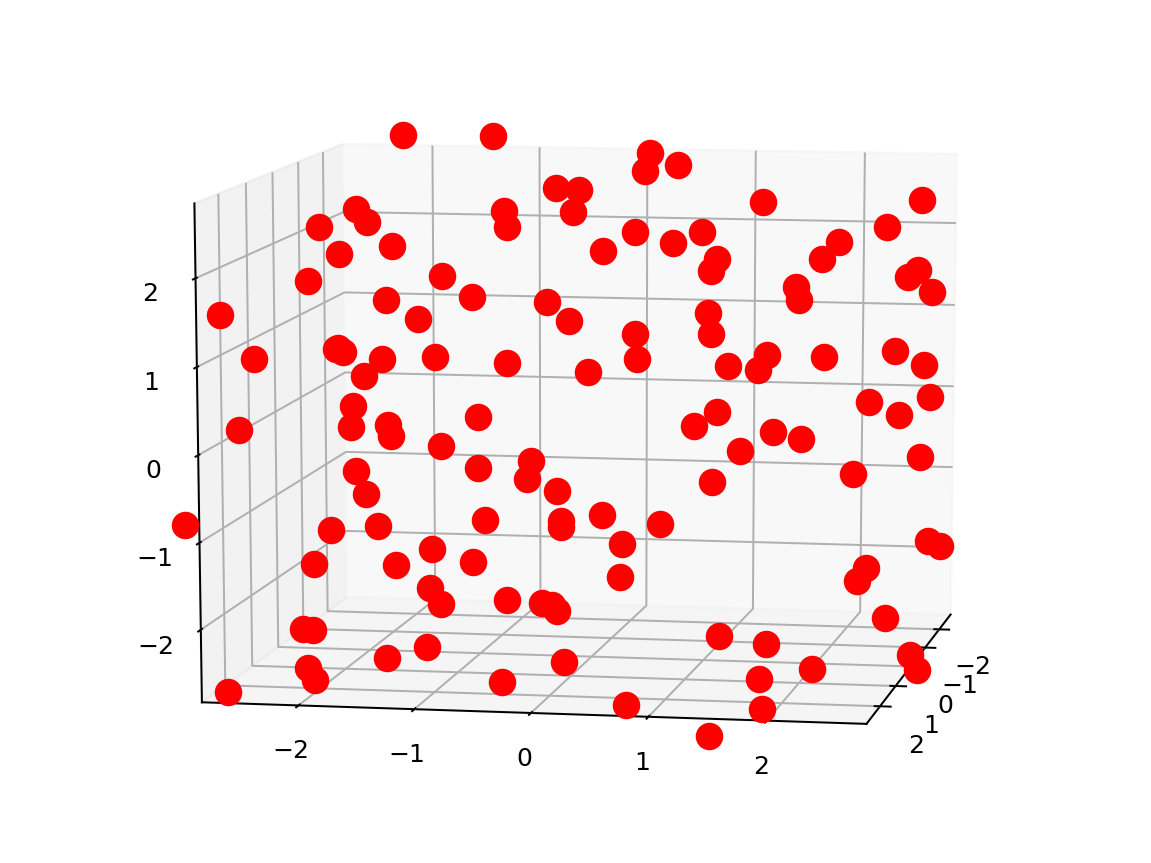

In [12]:
constants = num_dims, temperature, dt, gamma, boxl, potE_0, kinE_0

# set up figure and animation
fig = plt.figure()
if num_dims == 2:
    ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                         xlim=(-0.5*boxl, 0.5*boxl), ylim=(-0.5*boxl, 0.5*boxl))
    particles, = ax.plot([], [], 'bo', ms=ms)
elif num_dims == 3:
    ax = p3.Axes3D(fig)
    ax.set_xlim3d([-0.5*boxl, 0.5*boxl])
    ax.set_ylim3d([-0.5*boxl, 0.5*boxl])
    ax.set_zlim3d([-0.5*boxl, 0.5*boxl])
    particles, = ax.plot([], [], [], 'ro', ms=ms)
    

# The animation loop doesn't play nice with I/O it seems. Be sure to
# run the next block to close the file after the simulation finishes.
# There's probably a better way but it might take some digging.
fname = 'simulation_params.out'
f = open(fname, 'w+')

# Below line runs simulation and animation. Alternatively if you want
# to just run simulation, then you can loop the update function.
anim = FuncAnimation(fig, update, frames=num_steps-1, 
                     interval=1, blit=True, init_func=init, 
                     repeat=False, fargs=(params, constants, f, visualize, ms))

In [40]:
f.close()

## Checking Energies and Temperatures

In [41]:
energies = []
ke = []
pe = []
temperatures = []

with open(fname, 'r') as rf:
    for line in rf:
        line = line.replace(',', ' ')
        lsplit = line.split()
        temperatures.append(float(lsplit[3]))
        energies.append(float(lsplit[5]))
        

<IPython.core.display.Javascript object>


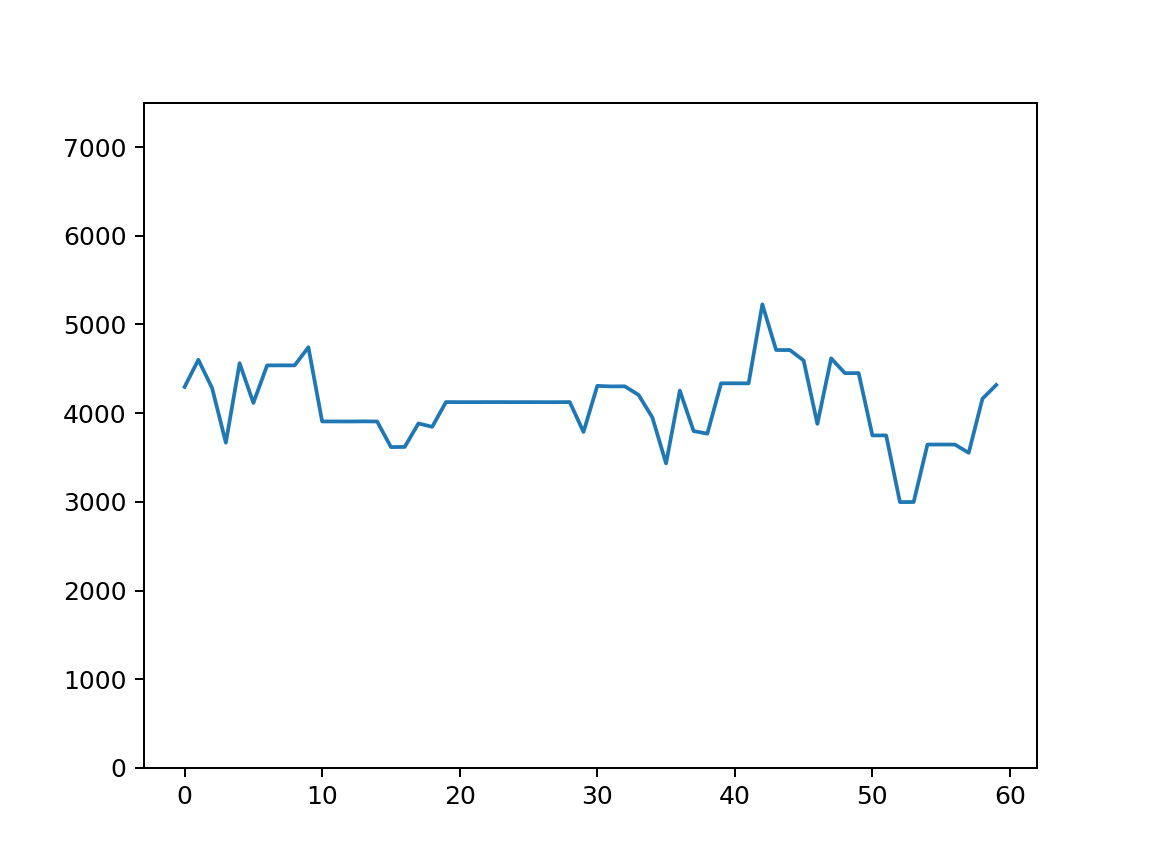

In [42]:
plt.plot(energies)
plt.ylim([0, 7500])
plt.show()

<IPython.core.display.Javascript object>


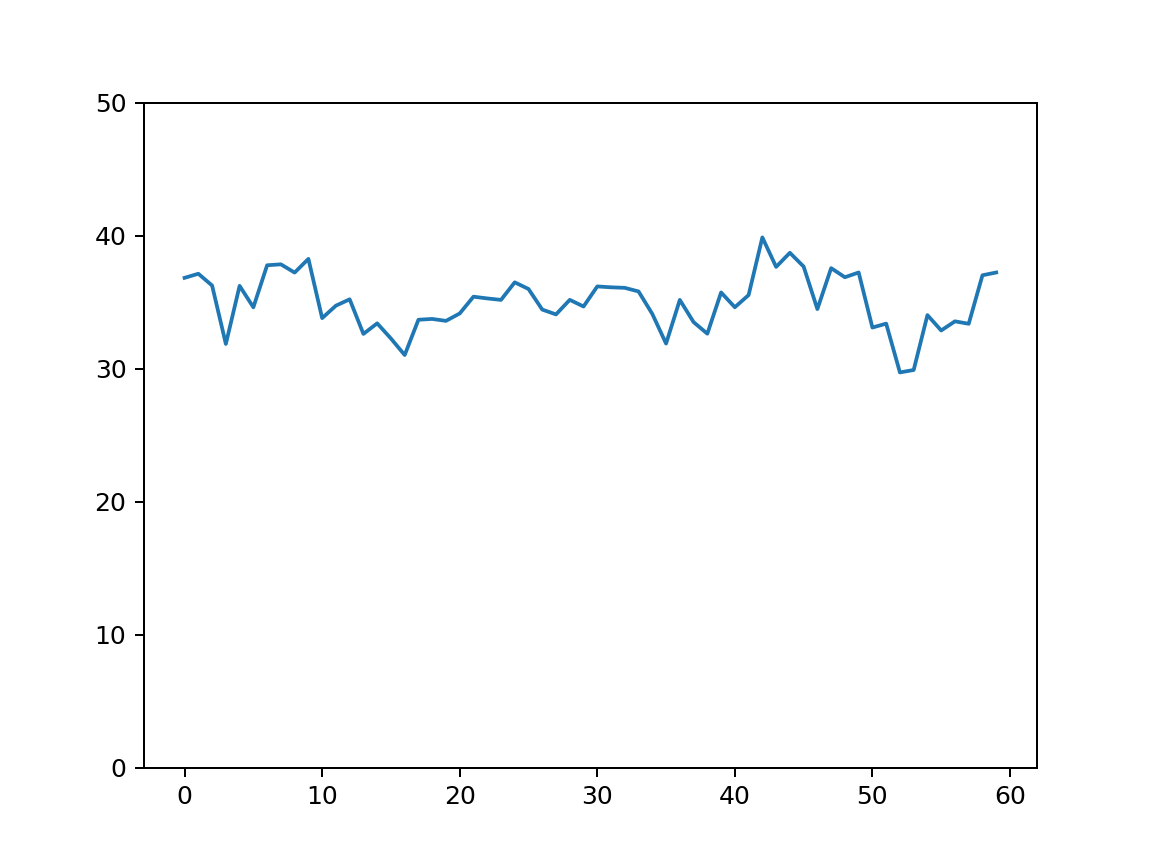

In [43]:
plt.plot(temperatures)
plt.ylim([0, 50])
plt.show()